In [1]:
import numpy as np
from Simulation.Motion import State, GPS, Drive
from matplotlib import pyplot as plt

bot_spec = {'wheelbase': 0.235,
            'wheel_velocity_range': [-0.5,0.5], # m/s, [min max]
            'min_wheel_speed': 0.0,
            'wheel_diameter': 0.072,
            'body_radius': 0.175,
            'wheelbase_offset': 0.0,
            'wheel_velocity_var': 0.0,
            #'steering_var': 1e-3, # not yet implemented
            'abs_min_turning_radius': 0.0,
            'L2R_bias_mean': 1.0,                                                                                                                                             
            'L2R_bias_var': 0.0,                                                                                                                                              
            'velo_var': 0.0,                                                                                                                                                 
            'heading_offset_mean': 0.0,                                                                                                                                  
            'heading_offset_var': 0.0}
%matplotlib inline

## Self-corrected Dubins Path with noisy GPS

### 1. Dubins Path Planning

In [9]:
from math import sin, cos, atan2, sqrt, acos, pi, hypot

In [7]:
def wrap_to_pi(a):
    if a >= pi:
        a -= 2*pi
    elif a < -pi:
        a += 2*pi
    return a

In [ ]:
def plan(start_pose, goal_pose, min_turn_radius, step_size=0.1, mode = 'LSL'):
    
    

_DUBINS_PATH_TYPES = {"LSL": _LSL, "RSR": _RSR, }
    
    
def _LSL(start_pose, goal_pose, min_turn_radius):
    modes = ['L','S','L']    
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]+pi/2),sin(start_pose[2]+pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]+pi/2),sin(goal_pose[2])+pi/2])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    A = C1 + r*np.array([cos(yaw_C2C1 - pi/2), sin(yaw_C2C1 - pi/2)])
    B = C2 + r*np.array([cos(yaw_C2C1 - pi/2), sin(yaw_C2C1 - pi/2)])
    A_pose = np.append(A, yaw_C2C1)
    B_pose = np.append(B, yaw_C2C1)
    
    d1 = np.abs(wrap_to_pi(A_pose[2] - start_pose[2])*r)
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = np.abs(wrap_to_pi(goal_pose[2] - B_pose[2])*r)
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distance = d1+d2+d3
    
    return inter_poses, distance, modes


def _RSR(start_pose, goal_pose, min_turn_radius):
    modes = ['R','S','R']
    r = min_turn_radius
    C1 = start_pose[:2] + r*np.array([cos(start_pose[2]-pi/2),sin(start_pose[2]-pi/2)])
    C2 = goal_pose[:2] + r*np.array([cos(goal_pose[2]-pi/2),sin(goal_pose[2])-pi/2])
    yaw_C2C1 = atan2(C2[1]-C1[1], C2[0]-C1[0])
    A = C1 + r*np.array([cos(yaw_C2C1 + pi/2), sin(yaw_C2C1 + pi/2)])
    B = C2 + r*np.array([cos(yaw_C2C1 + pi/2), sin(yaw_C2C1 + pi/2)])
    A_pose = np.append(A, yaw_C2C1)
    B_pose = np.append(B, yaw_C2C1)
    
    d1 = np.abs(wrap_to_pi(A_pose[2] - start_pose[2])*r)
    d2 = hypot(B[1]-A[1], B[0]-A[0])
    d3 = np.abs(wrap_to_pi(goal_pose[2] - B_pose[2])*r)
    
    inter_poses = {'A': A_pose, 'B': B_pose}
    distance = d1+d2+d3
    
    return inter_poses, distance, modes





    
    

In [80]:
state2 = State(pose=[0.0,0.0,0.0], kinematic = [0.1, 0.0], dt = 0.5)

In [81]:
state2.reset()

In [82]:
state2.reset()
sim_len = 500
poses = np.zeros((sim_len,3))
Rs = np.zeros(sim_len)
ICCs = np.zeros((sim_len,2))
kinematics = np.zeros((sim_len,2))
for i in range(sim_len):
    kinematics[i] = np.array(state2.kinematic)
    Rs[i] = state2.turning_radius()
    ICCs[i] = np.array(state2.ICC())
    state2.update_pose()
    poses[i] = state2.pose
    if i>91 and i<110:
        state2.update_kinematic(new_w = np.pi/18)
    elif i>182 and i<219:
        state2.update_kinematic(new_w = np.pi/36)
    elif i>300 and i<310:
        state2.update_kinematic(new_w = np.pi/9)
    elif i>400 and i<418:
        state2.update_kinematic(new_w = np.pi/17)
    else:
        state2.update_kinematic(new_w = 0.0)
        

In [83]:
state = State(pose=[0.0,0.0,0.0], kinematic = [0.1, 0.0], dt = 0.5)
gps = GPS(pose = [0.0, 0.0, 0.0], noise = True, mode='create', custom_spec=bot_spec)
drive = Drive(custom=True,custom_spec=bot_spec,noise=True)

In [84]:
state.reset()
drive.reset()
sim_len = len(kinematics)
poses_hat = np.zeros((sim_len,3))
kinematics_hat = np.zeros((sim_len,2))
state2.pose = gps.pose_hat
poses2_hat = np.zeros((sim_len,3))
for i, kine in enumerate(kinematics):
    drive.kinematic_update(kine)
    #print(kine)
    #print(drive.kinematic)
    state.update_kinematic(drive.kinematic)
    state.update_pose()
    gps.update(state.pose)
    poses_hat[i]=state.pose
    poses2_hat[i]=gps.pose_hat
    kinematics_hat[i]=state.kinematic
    

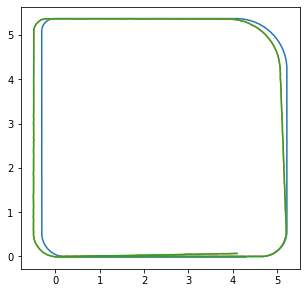

In [85]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(poses[:,0], poses[:,1])
ax.plot(poses_hat[:,0], poses_hat[:,1])
ax.plot(poses2_hat[:,0], poses2_hat[:,1])
ax.set_aspect('equal')


In [86]:
%matplotlib notebook

<IPython.core.display.Javascript object>


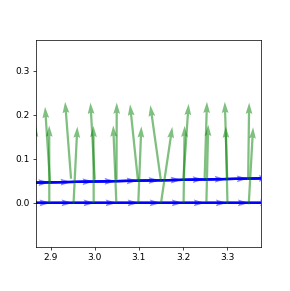

In [87]:
fig, ax = plt.subplots(figsize=(5,5))

plt.quiver(poses_hat[:,0],poses_hat[:,1],
           0.175*np.cos(poses_hat[:,2]),0.175*np.sin(poses_hat[:,2]),
           pivot='tail',scale_units='xy',scale=0.5,width=0.01,color='b',alpha=0.5)
plt.quiver(poses2_hat[:,0],poses2_hat[:,1],
           0.175*np.cos(poses2_hat[:,2]),0.175*np.sin(poses2_hat[:,2]),
           pivot='tail',scale_units='xy',scale=1,width=0.01,color='g',alpha=0.5)
ax.set_aspect('equal')


In [32]:
poses2_hat

array([[-0.00041962, -0.00165363,  0.06319663],
       [-0.00041962, -0.00165363,  0.06319663],
       [-0.00041962, -0.00165363,  0.06319663],
       ...,
       [-0.00041962, -0.00165363,  0.06319663],
       [-0.00041962, -0.00165363,  0.06319663],
       [-0.00041962, -0.00165363,  0.06319663]])

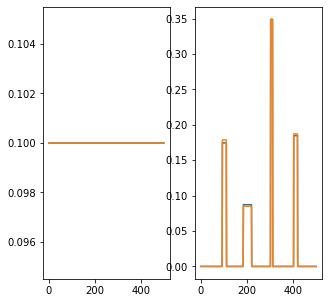

In [21]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].plot(kinematics[:,0])
ax[0].plot(kinematics_hat[:,0])
ax[1].plot(kinematics[:,1])
ax[1].plot(kinematics_hat[:,1])


In [9]:
members = [attr for attr in vars(drive.bot) if not callable(getattr(drive.bot, attr)) and not attr.startswith("__")]
print(members)

['wheelbase', 'wheel_velocity_range', 'wheel_diameter', 'min_wheel_speed', 'body_radius', 'wheelbase_offset', 'wheel_velocity_var', 'abs_min_turning_radius', 'L2R_bias_mean', 'L2R_bias_var', 'velo_var', 'heading_offset_mean', 'heading_offset_var', 'v_left_factor', 'v_right_factor', 'heading_offset']


In [ ]:
for attr in members:
    print(attr,'\t|\t', getattr(drive.bot, attr))